In [17]:
# import sys
# sys.path.insert(1, './wlcstat/')
import numpy as np
# import scipy.special as sp
# import scipy.optimize as opt
import matplotlib.pyplot as plt
import matplotlib.patches
import seaborn as sns
from matplotlib.colors import LogNorm

In [96]:
# load sf mat

ID = -9.4

settings = np.load(r"C:\Users\tmhab\wlcsim_membrane\chrom_stab\ID=%s_settings.npy" % (ID), allow_pickle = True)

[chrom, [klog_min, klog_max, klog_num]] = settings

[n_bind, v_int, chi, e_m, phi_c, poly_marks, mu_max, mu_min, del_mu, f_om, N, N_m, b] = chrom

mu1_array = np.arange(mu_min, mu_max, del_mu)
mu2_array = np.arange(mu_min, mu_max, del_mu)

k_vec = np.logspace(klog_min, klog_max, klog_num) / b
  
s2_mats = np.load(r"C:\Users\tmhab\wlcsim_membrane\chrom_stab\ID=%s_chrom_s2_mats_v_int=[[%s,%s],[%s,%s]],DNA,mu_max=%s.npy"\
                 % (ID, v_int[0,0], v_int[0,1], v_int[1,0], v_int[1,1], mu_max), allow_pickle = True)


In [97]:
print("v_int: ")
print(v_int)

print(r"phi_c: ")
print(phi_c)

print("mu max, min, del_mu:")
print(mu_max, mu_min, del_mu) 

print("k logspace min, max, tot num:")
print(klog_min, klog_max, klog_num)

v_int: 
[[0 0]
 [0 0]]
phi_c: 
0.6
mu max, min, del_mu:
0 -10 1
k logspace min, max, tot num:
-3 -1 30


In [42]:
N

36647.974528301886

In [121]:
# stab anal
# chi = 0.00083
chi = 0.00082


min_eigval_arr = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec)))
# min_eigval_arr_melt = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec)))
min_eigval_arr_ps = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec)))
# min_eigval_arr_soln1prot = np.zeros((len(mu1_array[:]),  len(mu2_array[:]), len(k_vec)))
# min_eigval_arr_melt_singprot = np.zeros((len(mu1_array[:]),  len(mu2_array[:]), len(k_vec[:25:1])))

S2_det_arr = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec[:])))


# S2_cond_arr_soln_2 = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec[:])))
# S2_cond_arr_soln_1 = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec[:])))
# S2_cond_arr_melt_2 = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec[:])))

max_cond_arr_allk = np.zeros((len(mu1_array[:]), len(mu2_array[:])))

min_eigval_arr_allk = np.zeros((len(mu1_array[:]), len(mu2_array[:])))
min_eigval_arr_allk_ps = np.zeros((len(mu1_array[:]), len(mu2_array[:])))
# min_eigval_arr_allk_melt = np.zeros((len(mu1_array[:]), len(mu2_array[:])))

k_star_arr = np.zeros((len(mu1_array[:]), len(mu2_array[:])))

for i, mu1 in enumerate(mu1_array[:]):
    for j, mu2 in enumerate(mu2_array[:]):
#         if mu1 == mu2:
#             continue
        mu = [mu1, mu2]

        for ik, k in enumerate(k_vec):
#             S2_mat = 1/N**2 * np.array([[cc[0], 0, cg1[0], cg2[0]],\
#                             [0, ss*N**2, 0, 0], \
#                             [cg1[0], 0, g1g1[0], g1g2[0]],\
#                             [cg2[0], 0, g2g1[0], g2g2[0]]])
        
            S2_mat =  s2_mats[i][j][ik]
        
            if phi_c >= 0.999:
                raise Exception("melt!")
                
                
            # FULL SOLUTION 2 reader proteins
            S2_det = np.linalg.det(S2_mat)

            S2_cond = np.linalg.cond(S2_mat)
            S2_cond_arr_soln_2[i][j][ik] = S2_cond
            S2_det_arr[i][j][ik] = S2_det
            
            
            if S2_det != 0:# and S2_cond < 1e10:
                S2_inv = np.linalg.inv(S2_mat)
    #             G2 = N* np.array([[S2_inv[0,0] - 2*chi/N + S2_inv[1,1], S2_inv[0,2], S2_inv[0, 3]],\
    #                [S2_inv[2,0], S2_inv[2,2] + v_int[0,0]/N, S2_inv[2,3] + v_int[0,1]/N],\
    #                [S2_inv[3,0], S2_inv[3,2] + v_int[1,0]/N, S2_inv[3,3] + v_int[1,1]/N]])

                G2 = (1/N)* np.array([[S2_inv[0,0] - 2*chi*N + S2_inv[1,1], S2_inv[0,2], S2_inv[0, 3]],\
                   [S2_inv[2,0], S2_inv[2,2] + N*v_int[0,0], S2_inv[2,3] + N*v_int[0,1]],\
                   [S2_inv[3,0], S2_inv[3,2] + N*v_int[1,0], S2_inv[3,3] + N*v_int[1,1]]])

                val, vec = np.linalg.eigh(G2)
                min_val = np.min(val)            
                min_eigval_arr[i][j][ik] = min_val
                
            # POLY/SOLV only
            S2_mat = np.array([[S2_mat[0,0], 0], [0, S2_mat[1,1]]])

            if phi_c >= 0.999:
                raise Exception("melt!")
            S2_det = np.linalg.det(S2_mat)           
            
            if S2_det != 0:# and S2_cond < 1e10:
                S2_inv = np.linalg.inv(S2_mat)

#                 G2 = (1/N)* np.array([S2_inv[0,0] - 2*chi*N + S2_inv[1,1]])
                G2 = np.array([S2_inv[0,0] - 2*chi + S2_inv[1,1]])

                val = G2[0]
                min_val = np.min(val)            
                min_eigval_arr_ps[i][j][ik] = min_val


        # all-k analysis

        min_vals = min_eigval_arr[i][j][:][np.nonzero(min_eigval_arr[i][j][:])] # min eigvals at mu1,mu2 for each k
        if len(min_vals) != 0:
            minval_allk = np.min(min_vals) # minimum eigenvalue at mu1,mu2 across all ks
            min_eigval_arr_allk[i][j] = minval_allk
            
            k_star = k_vec[np.where(min_vals==minval_allk)] # corresponding k 
            k_star_arr[i][j] = k_star

        min_vals_ps = min_eigval_arr[i][j][:][np.nonzero(min_eigval_arr_ps[i][j][:])] # min eigvals at mu1,mu2 for each k
        if len(min_vals_ps) != 0:
            minval_allk = np.min(min_vals_ps) # minimum eigenvalue at mu1,mu2 across all ks
            min_eigval_arr_allk_ps[i][j] = minval_allk
            
#         min_vals_melt = min_eigval_arr_melt[i][j][:] # min eigvals at mu1,mu2 for each k
#         minval_allk_melt = np.min(min_vals_melt) # minimum eigenvalue at mu1,mu2 across all ks
#         min_eigval_arr_allk_melt[i][j] = minval_allk_melt

        cond_nums = S2_cond_arr_soln_2[i][j][:]
        max_cond_allk = np.max(cond_nums)
        max_cond_arr_allk[i][j] = max_cond_allk
        


            

<Figure size 640x480 with 0 Axes>

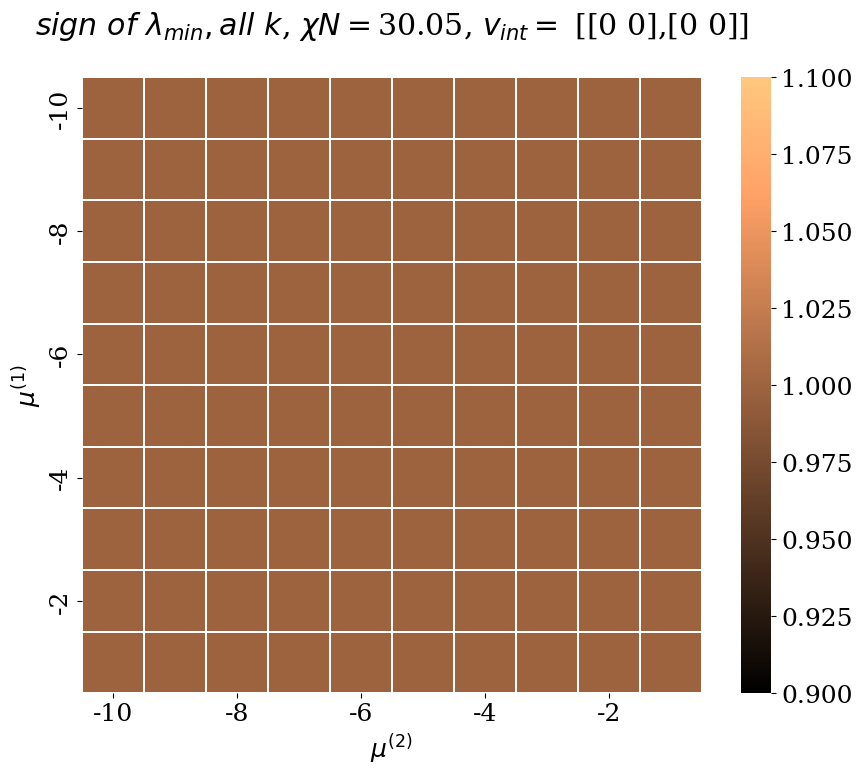

In [122]:
#density maps
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

# plt.scatter(mu1_array[np.where(multi_soln_mus == 1)[0]],mu2_array[np.where(multi_soln_mus == 1)[1]])
# k_ind = 20
ax = sns.heatmap(np.sign(min_eigval_arr_allk), linewidth=0.25, cmap = "copper", xticklabels=mu2_array, yticklabels=mu1_array)
# ax = sns.heatmap(np.sign(min_eigval_arr[0:3][0:3][k_ind]), linewidth=0.1, cmap = "winter", cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
# protein 1
# ax = sns.heatmap(f_gam_soln_arr[0], linewidth=0.5, cmap = "winter", xticklabels=mu2_array, yticklabels=mu1_array, cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
ax.set_xticks(ax.get_xticks()[::2])
ax.set_xticklabels(mu2_array[::2].astype(np.int64))
ax.set_yticks(ax.get_yticks()[::2])
ax.set_yticklabels(mu1_array[::2].astype(np.int64))

plt.ylabel("$\mu^{(1)}$")
plt.xlabel("$\mu^{(2)}$")
plt.title(r"$ sign \ of \ \lambda_{min}, all \ k$" +  ", $\chi N = $" + \
          str(np.round(chi*N, 2)) \
          +  ", $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "]"+\
          "\n")


plt.show()


<Figure size 640x480 with 0 Axes>

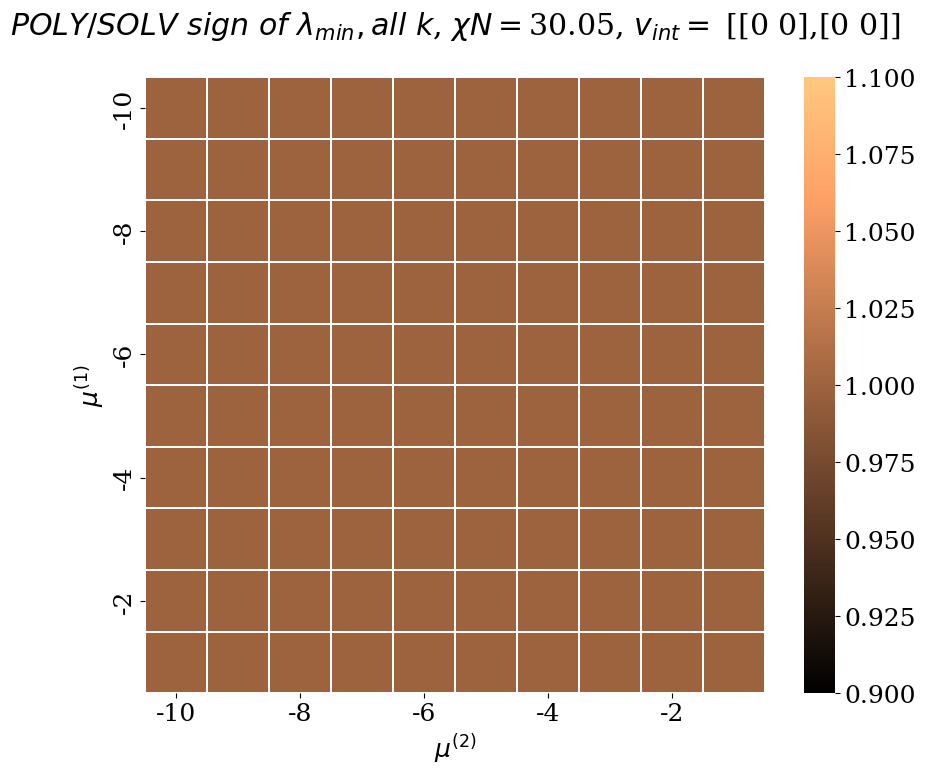

In [123]:
#density maps
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

# plt.scatter(mu1_array[np.where(multi_soln_mus == 1)[0]],mu2_array[np.where(multi_soln_mus == 1)[1]])
# k_ind = 20
ax = sns.heatmap(np.sign(min_eigval_arr_allk_ps), linewidth=0.25, cmap = "copper", xticklabels=mu2_array, yticklabels=mu1_array)
# ax = sns.heatmap(np.sign(min_eigval_arr[0:3][0:3][k_ind]), linewidth=0.1, cmap = "winter", cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
# protein 1
# ax = sns.heatmap(f_gam_soln_arr[0], linewidth=0.5, cmap = "winter", xticklabels=mu2_array, yticklabels=mu1_array, cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
ax.set_xticks(ax.get_xticks()[::2])
ax.set_xticklabels(mu2_array[::2].astype(np.int64))
ax.set_yticks(ax.get_yticks()[::2])
ax.set_yticklabels(mu1_array[::2].astype(np.int64))

plt.ylabel("$\mu^{(1)}$")
plt.xlabel("$\mu^{(2)}$")
plt.title(r"$ POLY/SOLV \ sign \ of \ \lambda_{min}, all \ k$" +  ", $\chi N = $" + \
          str(np.round(chi*N, 2)) \
          +  ", $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "]"+\
          "\n")


plt.show()


In [31]:
# #density maps
# fig = plt.figure()
# plt.figure(figsize=(10,8))

# font = {'family' : 'serif',
#         'weight':'normal',
#         'size': 18}
# plt.rc('font', **font)

# # plt.scatter(mu1_array[np.where(multi_soln_mus == 1)[0]],mu2_array[np.where(multi_soln_mus == 1)[1]])
# k_ind = 0
# ax = sns.heatmap(np.sign(min_eigval_arr[:,:,k_ind]), linewidth=0.25, cmap = "copper", xticklabels=mu2_array, yticklabels=mu1_array)
# # ax = sns.heatmap(np.sign(min_eigval_arr[0:3][0:3][k_ind]), linewidth=0.1, cmap = "winter", cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
# # protein 1
# # ax = sns.heatmap(f_gam_soln_arr[0], linewidth=0.5, cmap = "winter", xticklabels=mu2_array, yticklabels=mu1_array, cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
# ax.set_xticks(ax.get_xticks()[::2])
# ax.set_xticklabels(mu2_array[::2].astype(np.int64))
# ax.set_yticks(ax.get_yticks()[::2])
# ax.set_yticklabels(mu1_array[::2].astype(np.int64))

# plt.ylabel("$\mu^{(1)}$")
# plt.xlabel("$\mu^{(2)}$")
# plt.title(r"$ sign \ of \ \lambda_{min}, k = $" + str(np.round(k_vec[k_ind], 4)) +  ", $\chi = $" + \
#           str(chi) \
#           +  ", $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "]"+\
#           "\n")


# plt.show()


<Figure size 640x480 with 0 Axes>

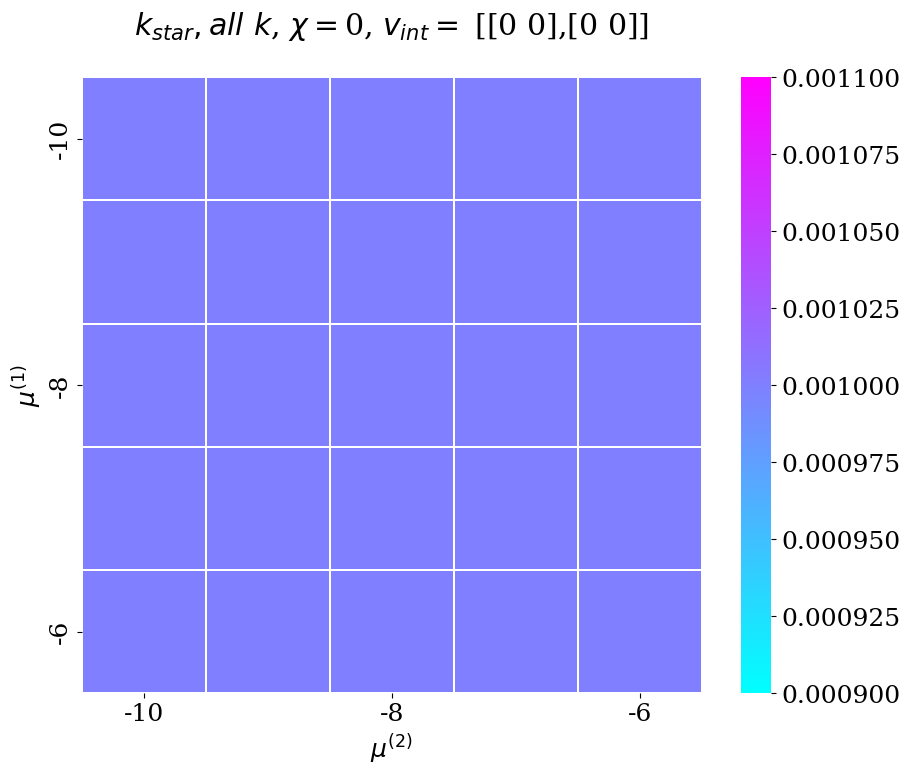

In [14]:
#density maps
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

# plt.scatter(mu1_array[np.where(multi_soln_mus == 1)[0]],mu2_array[np.where(multi_soln_mus == 1)[1]])
# k_ind = 20
ax = sns.heatmap(k_star_arr, linewidth=0.25, cmap = "cool", xticklabels=mu2_array, yticklabels=mu1_array)
# ax = sns.heatmap(np.sign(min_eigval_arr[0:3][0:3][k_ind]), linewidth=0.1, cmap = "winter", cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
# protein 1
# ax = sns.heatmap(f_gam_soln_arr[0], linewidth=0.5, cmap = "winter", xticklabels=mu2_array, yticklabels=mu1_array, cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
ax.set_xticks(ax.get_xticks()[::2])
ax.set_xticklabels(mu2_array[::2].astype(np.int64))
ax.set_yticks(ax.get_yticks()[::2])
ax.set_yticklabels(mu1_array[::2].astype(np.int64))

plt.ylabel("$\mu^{(1)}$")
plt.xlabel("$\mu^{(2)}$")
plt.title(r"$ k_{star}, all \ k$" +  ", $\chi = $" + \
          str(chi) \
          +  ", $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "]" +\
          "\n")


plt.show()


<Figure size 640x480 with 0 Axes>

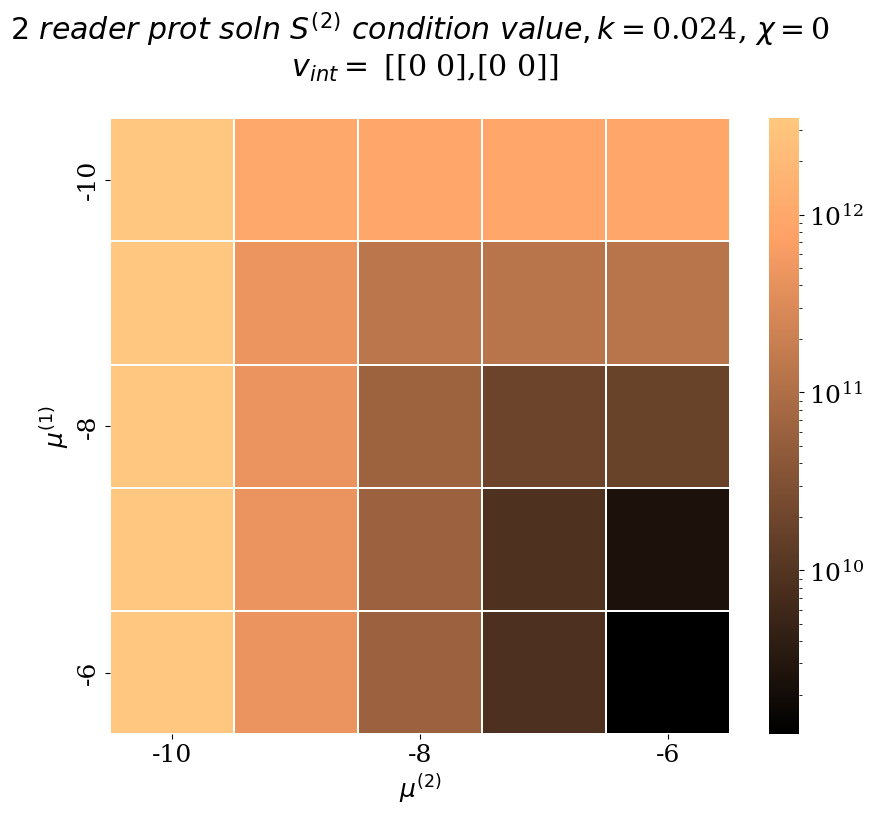

In [19]:
#density maps
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

# plt.scatter(mu1_array[np.where(multi_soln_mus == 1)[0]],mu2_array[np.where(multi_soln_mus == 1)[1]])
k_ind = 20
ax = sns.heatmap(S2_cond_arr_soln_2[:,:,k_ind], linewidth=0.25, norm = LogNorm(), cmap = "copper", xticklabels=mu2_array, yticklabels=mu1_array)
# ax = sns.heatmap(np.sign(min_eigval_arr[0:3][0:3][k_ind]), linewidth=0.1, cmap = "winter", cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
# protein 1
# ax = sns.heatmap(f_gam_soln_arr[0], linewidth=0.5, cmap = "winter", xticklabels=mu2_array, yticklabels=mu1_array, cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
ax.set_xticks(ax.get_xticks()[::2])
ax.set_xticklabels(mu2_array[::2].astype(np.int64))
ax.set_yticks(ax.get_yticks()[::2])
ax.set_yticklabels(mu1_array[::2].astype(np.int64))

plt.ylabel("$\mu^{(1)}$")
plt.xlabel("$\mu^{(2)}$")
plt.title(r"$ 2 \ reader \ prot \ soln \  S^{(2)} \ condition \ value, k = $" + str(np.round(k_vec[k_ind], 4)) +  ", $\chi = $" + \
          str(chi)+\
          "\n" +  " $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "]"+\
          "\n")

plt.show()
